In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from backend.common.state_resolver import resolve_state
from backend.ml.common import get_total_enrolment_series

from backend.ml.anomaly.train import train_baseline_model
from backend.ml.registry import load_model
from backend.ml.anomaly.predict import build_features


In [2]:
state_in = "UP"
state = resolve_state(state_in)

series = get_total_enrolment_series(state=state)

df = pd.DataFrame(series)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")

df.tail()


,date,total_enrolment
83,2025-12-26,9933
84,2025-12-27,6982
85,2025-12-28,7902
86,2025-12-29,7360
87,2025-12-31,26655


In [3]:
train_baseline_model(state=state)


{'status': 'trained', 'model': 'baseline_expected_Uttar Pradesh', 'rows': 81}

In [4]:
baseline = load_model(f"baseline_expected_{state}") or load_model("baseline_expected_global")
assert baseline is not None

df_feat = df.copy()
df_feat = build_features(df_feat).dropna()

X = df_feat[["dayofweek", "month", "day", "lag_1", "lag_7", "roll_7"]]
df_feat["expected"] = baseline.predict(X)
df_feat["gap"] = df_feat["total_enrolment"] - df_feat["expected"]

df_feat.tail()


,date,total_enrolment,dayofweek,month,day,lag_1,lag_7,roll_7,expected,gap
83,2025-12-26,9933,4,12,26,8804.0,7664.0,9718.285714,9325.570,607.430
84,2025-12-27,6982,5,12,27,9933.0,20798.0,7744.571429,6852.665,129.335
85,2025-12-28,7902,6,12,28,6982.0,2543.0,8510.142857,7925.535,-23.535
86,2025-12-29,7360,0,12,29,7902.0,14345.0,7512.285714,7211.770,148.230
87,2025-12-31,26655,2,12,31,7360.0,4867.0,10624.857143,20823.135,5831.865


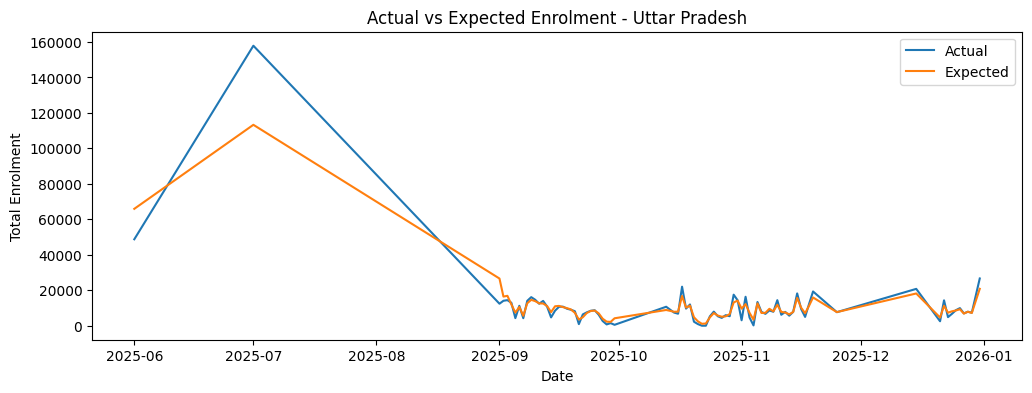

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df_feat["date"], df_feat["total_enrolment"], label="Actual")
plt.plot(df_feat["date"], df_feat["expected"], label="Expected")
plt.title(f"Actual vs Expected Enrolment - {state}")
plt.xlabel("Date")
plt.ylabel("Total Enrolment")
plt.legend()
plt.show()


In [6]:
y_true = df_feat["total_enrolment"]
y_pred = df_feat["expected"]

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5

{"state": state, "MAE": mae, "RMSE": rmse}


{'state': 'Uttar Pradesh',
 'MAE': 2364.9418518518514,
 'RMSE': 5883.255807759545}

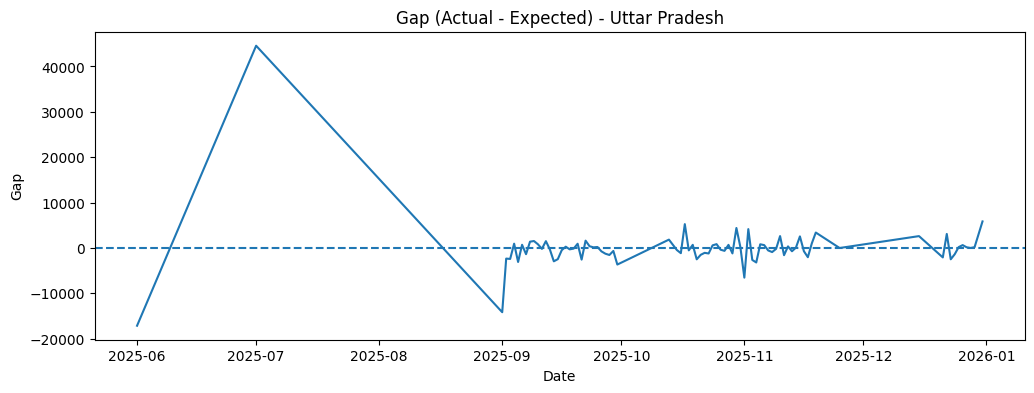

In [7]:
plt.figure(figsize=(12,4))
plt.plot(df_feat["date"], df_feat["gap"])
plt.axhline(0, linestyle="--")
plt.title(f"Gap (Actual - Expected) - {state}")
plt.xlabel("Date")
plt.ylabel("Gap")
plt.show()


In [8]:
from backend.ml.forecast.train import train_forecast_model
from backend.ml.forecast.predict import forecast

train_forecast_model(state=state)
pred = forecast(state=state, days=30)

pred["status"], len(pred["forecast"])


('success', 30)

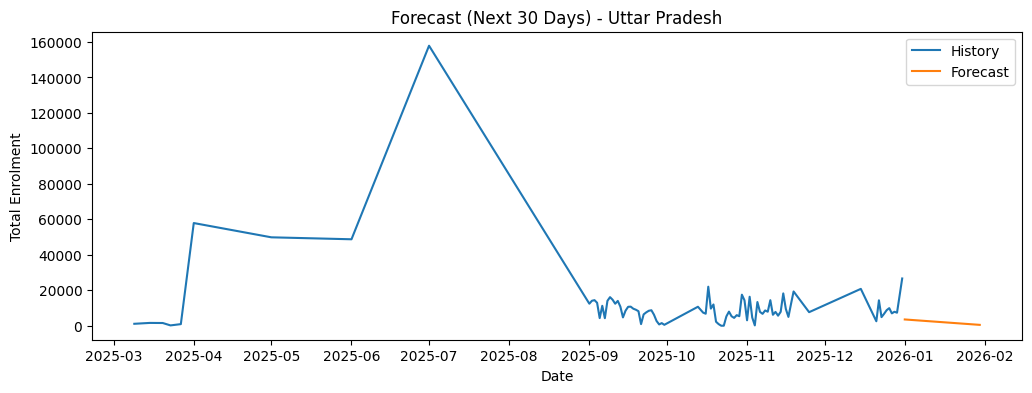

In [9]:
df_fore = pd.DataFrame(pred["forecast"])
df_fore["date"] = pd.to_datetime(df_fore["date"])

plt.figure(figsize=(12,4))
plt.plot(df["date"], df["total_enrolment"], label="History")
plt.plot(df_fore["date"], df_fore["predicted_total_enrolment"], label="Forecast")
plt.title(f"Forecast (Next 30 Days) - {state}")
plt.xlabel("Date")
plt.ylabel("Total Enrolment")
plt.legend()
plt.show()
